In [1]:
import os 

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap

import torch
from scvi.dataset import CsvDataset, LoomDataset, AnnDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

import tempfile
import uuid

In [2]:
!ls -lhtr ../data

total 8.9G
-rw-rw-r-- 1 ubuntu ubuntu 6.9M Dec 20 00:52 CellBench_sce10x_qc.csv.gz
-rw-rw-r-- 1 ubuntu ubuntu  40K Dec 20 00:52 CellBench_sce10x_qc_cols.csv.gz
-rw-rw-r-- 1 ubuntu ubuntu 2.0M Dec 20 00:52 CellBench_sce4_qc.csv.gz
-rw-rw-r-- 1 ubuntu ubuntu  16K Dec 20 00:52 CellBench_sce4_qc_cols.csv.gz
-rw-rw-r-- 1 ubuntu ubuntu 1.3M Dec 20 00:52 CellBench_scedrop_qc.csv.gz
-rw-rw-r-- 1 ubuntu ubuntu  11K Dec 20 00:52 CellBench_scedrop_qc_cols.csv.gz
-rw-rw-r-- 1 ubuntu ubuntu 1.6M Dec 20 00:52 scvi-stuffnthings.pkl
-rw-rw-r-- 1 ubuntu ubuntu 382M Dec 20 19:09 tm_10x_v3.zip
drwxrwxr-x 4 ubuntu ubuntu  115 Dec 20 19:09 tm_10x_v3
-rw-rw-r-- 1 ubuntu ubuntu 297M Dec 20 19:09 tm_smart_v8.zip
drwxrwxr-x 4 ubuntu ubuntu  103 Dec 20 19:09 tm_smart_v8
-rw-r--r-- 1 ubuntu ubuntu 783M Dec 20 19:36 tm_mega.loom
-rw-r--r-- 1 ubuntu ubuntu 300M Dec 20 22:01 tm_10x.loom
-rw-r--r-- 1 ubuntu ubuntu 460M Dec 20 22:02 tm_smart.loom
-rw-r--r-- 1 ubuntu ubuntu 1.9G Dec 21 17:42 tm_mega.h5ad
-rw-r--r-- 1 

## Helper functions

## Train model

### parameters

In [3]:
n_epochs_all = None
base_path = '../data/'
n_epochs=50 if n_epochs_all is None else n_epochs_all # should _probably_ make this longer.
# But time was of the essence and the thing does train pretty quickly.
lr=1e-3
use_batches=True
use_cuda=True

In [4]:
smart = AnnDataset('../data/tm_smart.h5ad', save_path=base_path)

File ../data/../data/tm_smart.h5ad already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [5]:
smart.obs

,Neurog3>0_raw,Neurog3>0_scaled,batch,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,n_counts,...,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
index,,,,,,,,,,,,,,,,,,,,,
L4.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,mesenchymal stem cell,CL:0000134,1.0,nan,3_11_M,M,1383138.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,0.451009,-27.265811
D1.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,skeletal muscle satellite cell,CL:0000594,0.0,nan,3_11_M,M,859075.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,-7.130330,2.513948
N2.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,endothelial cell,CL:0000115,3.0,nan,3_11_M,M,912293.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,27.328518,-3.247341
H4.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,skeletal muscle satellite cell,CL:0000594,2.0,nan,3_11_M,M,1045840.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,-5.014913,-3.600054
E1.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,skeletal muscle satellite cell,CL:0000594,0.0,nan,3_11_M,M,697755.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,-12.420565,-5.319626
A6.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,skeletal muscle satellite cell,CL:0000594,0.0,nan,3_11_M,M,312934.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,-11.112084,5.911584
O2.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,B cell,CL:0000236,4.0,nan,3_11_M,M,715723.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,-24.037790,14.645776
I4.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,mesenchymal stem cell,CL:0000134,1.0,nan,3_11_M,M,1231320.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,6.077107,-19.287467
F1.D042103.3_11_M.1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,nan,nan,0,skeletal muscle satellite cell,CL:0000594,0.0,nan,3_11_M,M,896766.0,...,nan,NaN,nan,NaN,nan,NaN,ForelimbandHindlimb,Limb_Muscle,-8.923352,2.477643


In [6]:
tenx = AnnDataset('../data/tm_10x.h5ad', save_path=base_path)

File ../data/../data/tm_10x.h5ad already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [7]:
tenx.subsample_genes(new_n_genes=500)

Downsampling from 23433 to 500 genes
Downsampling from 55659 to 55659 cells


In [8]:
tenx.gene_names

array(['Beta-s', 'S100a8', 'S100a9', 'Scgb1a1', 'Krt4', 'Mt4', 'Malat1',
       'Dcpp3', 'Krt36', 'Lgals7', 'Camp', 'Cytl1', 'Rplp0', 'Krt14',
       'Ngp', 'Sftpc', 'Tmsb4x', 'Krt6a', 'Mgp', 'Eef1a1', 'Rpl13',
       'Rplp1', 'Rn45s', 'Rpl41', 'Krt13', 'Cd74', 'Rpl13a', 'Fabp5',
       'Rps19', 'Hspb1', 'Rpl32', 'Rps18', 'Rpl18a', 'Rps14', 'Krt16',
       'Gstm1', 'Gsn', 'Kap', 'Rps8', 'Krtdap', 'Bpifa1', 'Rps4x', 'Gpx3',
       'Rps2', 'Alb', 'Rps23', 'Rps29', 'Dcpp2', 'Uba52', 'Mt1', 'Rpl37a',
       'Rps5', 'Sfn', 'Ftl1', 'Rpl14', 'Rps16', 'Rps24', 'Sbpl', 'Mt2',
       'Rpl23a', 'Rps6', 'Rpl23', 'Ly6d', 'Actb', 'Rps3a', 'Lyz2',
       'Rps27a', 'Rpl35', 'Rpl10', 'S100a6', 'Rpl17', 'Rps12', 'Rps7',
       'Rps3', 'Rpl37', 'Actg1', 'Rps11', 'Rplp2', 'Ptma', 'Fth1',
       'Rpl27a', 'Dcn', 'Tpt1', 'Krt17', 'Rpl9', 'Tg', 'Rpl8', 'Rps20',
       'Dmkn', 'Cnfn', 'Apoa2', 'Rpl6', 'Rps9', 'Igj', 'Fau', 'Perp',
       'Rpl35a', 'Rpl19', 'Apoe', 'Rpl3', 'Rpl11', 'Krt76', 'Rps15a',
       'R

### train model

In [9]:
vae = VAE(tenx.nb_genes, n_batch=tenx.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              tenx,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)

trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 50/50 [02:58<00:00,  3.75s/it]


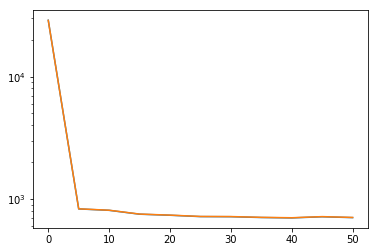

In [10]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,50,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.yscale('log')

### save model

In [ ]:
model_name = 'scvi-muris.pkl'
final_state = vae.state_dict()
torch.save(final_state, os.path.join(base_path, model_name))

### load model

In [ ]:
vae_loaded = VAE(scvi_data.nb_genes, n_batch=scvi_data.n_batches * use_batches)
vae_loaded.load_state_dict(torch.load(os.path.join(base_path, model_name)))

## visualize latent representations

In [11]:
len(tenx)

55659

In [13]:
# trainer.train_set.show_t_sne(n_samples=len(tenx), color_by='labels')

In [14]:
torch.cuda.empty_cache()

In [15]:
tenx_tensor = torch.cuda.FloatTensor(tenx.X)

In [16]:
tenx_tensor = tenx_tensor.cuda()

In [17]:
z = vae.sample_from_posterior_z(tenx_tensor, give_mean=True)
z = z.cpu().detach().numpy()
del tenx_tensor
torch.cuda.empty_cache()

In [18]:
smart.filter_genes(tenx.gene_names)

Downsampling from 23433 to 500 genes
Downsampling from 45423 to 45423 cells


In [19]:
smart.gene_names

array(['Beta-s', 'S100a8', 'S100a9', 'Scgb1a1', 'Krt4', 'Mt4', 'Malat1',
       'Dcpp3', 'Krt36', 'Lgals7', 'Camp', 'Cytl1', 'Rplp0', 'Krt14',
       'Ngp', 'Sftpc', 'Tmsb4x', 'Krt6a', 'Mgp', 'Eef1a1', 'Rpl13',
       'Rplp1', 'Rn45s', 'Rpl41', 'Krt13', 'Cd74', 'Rpl13a', 'Fabp5',
       'Rps19', 'Hspb1', 'Rpl32', 'Rps18', 'Rpl18a', 'Rps14', 'Krt16',
       'Gstm1', 'Gsn', 'Kap', 'Rps8', 'Krtdap', 'Bpifa1', 'Rps4x', 'Gpx3',
       'Rps2', 'Alb', 'Rps23', 'Rps29', 'Dcpp2', 'Uba52', 'Mt1', 'Rpl37a',
       'Rps5', 'Sfn', 'Ftl1', 'Rpl14', 'Rps16', 'Rps24', 'Sbpl', 'Mt2',
       'Rpl23a', 'Rps6', 'Rpl23', 'Ly6d', 'Actb', 'Rps3a', 'Lyz2',
       'Rps27a', 'Rpl35', 'Rpl10', 'S100a6', 'Rpl17', 'Rps12', 'Rps7',
       'Rps3', 'Rpl37', 'Actg1', 'Rps11', 'Rplp2', 'Ptma', 'Fth1',
       'Rpl27a', 'Dcn', 'Tpt1', 'Krt17', 'Rpl9', 'Tg', 'Rpl8', 'Rps20',
       'Dmkn', 'Cnfn', 'Apoa2', 'Rpl6', 'Rps9', 'Igj', 'Fau', 'Perp',
       'Rpl35a', 'Rpl19', 'Apoe', 'Rpl3', 'Rpl11', 'Krt76', 'Rps15a',
       'R

In [20]:
smart_tensor = torch.cuda.FloatTensor(smart.X)
z_transfer = vae.sample_from_posterior_z(smart_tensor, give_mean=True)
z_transfer = z_transfer.cpu().detach().numpy()
del smart_tensor
torch.cuda.empty_cache()

In [21]:
def umap_latent(z):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(z)
    embedding.shape
    plt.scatter(embedding[:,0], embedding[:,1])
    return embedding

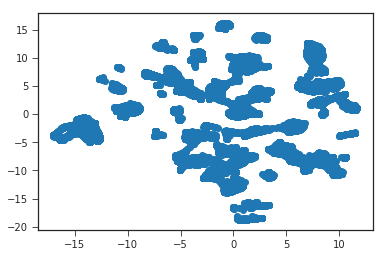

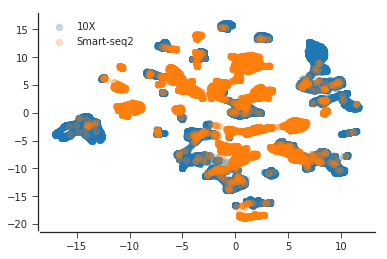

In [22]:
z_tot = np.concatenate([z, z_transfer])

sns.set_style('ticks')
emb = umap_latent(z_tot)

a = emb[0:len(tenx), :]
b = emb[len(tenx):, :]
plt.figure()
plt.scatter(a[:,0], a[:,1], alpha=0.25)
plt.scatter(b[:,0], b[:,1], alpha=0.25)
plt.legend(['10X', 'Smart-seq2'])
sns.despine(offset=2)

In [23]:
z.shape, z_transfer.shape

((55659, 10), (45423, 10))

In [24]:
a.shape, b.shape

((55659, 2), (45423, 2))

In [25]:
res = pd.DataFrame(emb)
res = res.rename(columns = {0:'x', 1:'y'})
res['tech'] = '10X'
res.loc[0:len(tenx), 'tech'] = '10X'
res.loc[len(tenx):, 'tech'] = 'Smart-seq2'
res.shape

(101082, 3)

In [26]:
res.to_csv('../cell_bench.csv')

In [30]:
# Wow - the scVI AnnDataset class is really terrible. It doesn't get the metadata.
# I'm going to leave this at this stage, because I'm guessing that someone else
# is far more competent than I am at getting the metadata out of the AnnData object
# (where it actually is stored), and lining that up with this dataframe.
# I will note that if someone really wanted to, you could just write:
# self.obs = ad.obs in the preprocess function (maybe throw on a copy if you want to)
# to get access to obsm here.
# I may yet do this, but I'm running out of time since that'd require re-running all
# of this stuff again, and it takes quite a while per run b/w tsne and umap.

# Addl update: OK. I did it. Only on the version of scVI installed on the AWS instance
# in the pytorch_p36 kernel. Anywhere else, the following items will fail horribly.
# Pushed a little bit upstream, but it'll need more work
# see https://github.com/YosefLab/scVI/pull/255 and
# https://github.com/YosefLab/scVI/issues/254
annots = pd.concat([tenx.obs, smart.obs])

In [44]:
zdf = pd.DataFrame(z_tot)
zdf = zdf.add_prefix('Activation')
z_tot_df = pd.DataFrame(z_tot, index=annots.index)
z_annot = pd.concat([z_tot_df, annots])
z_annot['tech'] = res.tech
z_annot

,0,1,2,3,4,5,6,7,8,9,...,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2,tech
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACAGGCT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.249308,1.656355,1.154050,-0.020438,0.528117,0.785549,0.135998,0.247834,1.173076,-0.512341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGAGAGTCTGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-1.502143,1.743973,0.132019,-1.210783,1.316239,1.698961,-1.097305,-0.323651,1.435529,-1.258542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGCAGGAATGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.069321,2.285406,1.246042,-0.601740,1.258820,0.294943,-0.282123,0.803977,1.151730,-0.027439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGGTACCGTAT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.348019,1.695186,1.200542,-0.440231,2.203150,0.426025,-0.625446,0.040991,1.254572,0.094661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGGTCAAACTC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.755758,0.419224,-0.187054,0.994134,-0.066220,0.986224,-1.423321,-0.724838,0.951319,0.521767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGGTCGGCTCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.626729,1.538016,0.517978,0.079368,0.588918,1.033007,-0.188774,-0.313159,1.320290,-0.171051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGTCCCGGATG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.272982,1.600736,0.503266,-0.018755,1.008340,0.592660,-0.156734,-0.642807,1.241682,-0.105282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGATGAGACCCACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.038269,2.236171,1.486858,-0.530314,1.898422,0.076317,-0.564656,0.189460,1.272757,0.211226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGATGAGTAGATGT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.237469,1.290829,0.263054,-0.696849,1.489202,1.537854,-0.701377,-1.029775,0.810621,-0.349017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0                10X
1                10X
2                10X
3                10X
4                10X
5                10X
6                10X
7                10X
8                10X
9                10X
10               10X
11               10X
12               10X
13               10X
14               10X
15               10X
16               10X
17               10X
18               10X
19               10X
20               10X
21               10X
22               10X
23               10X
24               10X
25               10X
26               10X
27               10X
28               10X
29               10X
             ...    
101052    Smart-seq2
101053    Smart-seq2
101054    Smart-seq2
101055    Smart-seq2
101056    Smart-seq2
101057    Smart-seq2
101058    Smart-seq2
101059    Smart-seq2
101060    Smart-seq2
101061    Smart-seq2
101062    Smart-seq2
101063    Smart-seq2
101064    Smart-seq2
101065    Smart-seq2
101066    Smart-seq2
101067    Smart-seq2
101068    Sma

In [39]:
z_annot

,0,1,2,3,4,5,6,7,8,9,...,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2,tech
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACAGGCT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.249308,1.656355,1.154050,-0.020438,0.528117,0.785549,0.135998,0.247834,1.173076,-0.512341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGAGAGTCTGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-1.502143,1.743973,0.132019,-1.210783,1.316239,1.698961,-1.097305,-0.323651,1.435529,-1.258542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGCAGGAATGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.069321,2.285406,1.246042,-0.601740,1.258820,0.294943,-0.282123,0.803977,1.151730,-0.027439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGGTACCGTAT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.348019,1.695186,1.200542,-0.440231,2.203150,0.426025,-0.625446,0.040991,1.254572,0.094661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGGTCAAACTC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.755758,0.419224,-0.187054,0.994134,-0.066220,0.986224,-1.423321,-0.724838,0.951319,0.521767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGGTCGGCTCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.626729,1.538016,0.517978,0.079368,0.588918,1.033007,-0.188774,-0.313159,1.320290,-0.171051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGTCCCGGATG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.272982,1.600736,0.503266,-0.018755,1.008340,0.592660,-0.156734,-0.642807,1.241682,-0.105282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGATGAGACCCACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.038269,2.236171,1.486858,-0.530314,1.898422,0.076317,-0.564656,0.189460,1.272757,0.211226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGATGAGTAGATGT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.237469,1.290829,0.263054,-0.696849,1.489202,1.537854,-0.701377,-1.029775,0.810621,-0.349017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
z_annot.to_csv("../tabula-muris_annot-latent-spaces.csv")

In [37]:

longzdf = pd.wide_to_long(z_annot.reset_index(), 'Activation', i="index", j="LV")
longzdf = longzdf.reset_index(level=0).reset_index(level=0)
del longzdf['index']
longzdf.to_csv('../cell_bench_embedding.csv', index=0)
longzdf

ValueError: the id variables need to uniquely identify each row